<a href="https://colab.research.google.com/github/DenisKai7/GroUp/blob/ml-training/GroUp_stunting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dataset dari github

In [3]:
!git clone https://github.com/DenisKai7/GroUp.git

fatal: destination path 'GroUp' already exists and is not an empty directory.


In [4]:
%cd GroUp
!git checkout dataset

/content/GroUp
Already on 'dataset'
Your branch is up to date with 'origin/dataset'.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6727 - loss: 0.6428 - val_accuracy: 0.6672 - val_loss: 0.5950
Epoch 2/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6909 - loss: 0.5837 - val_accuracy: 0.6580 - val_loss: 0.5935
Epoch 3/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7094 - loss: 0.5728 - val_accuracy: 0.6672 - val_loss: 0.5846
Epoch 4/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6768 - loss: 0.5827 - val_accuracy: 0.6702 - val_loss: 0.5827
Epoch 5/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6899 - loss: 0.5762 - val_accuracy: 0.6794 - val_loss: 0.5789
Epoch 6/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7059 - loss: 0.5648 - val_accuracy: 0.6718 - val_loss: 0.5804
Epoch 7/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7044 - loss: 0.5703 - val_accuracy: 0.6809 - val_loss: 0.5761
Epoch 8/87
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6860 - loss: 0.5734 - val_accuracy: 0.

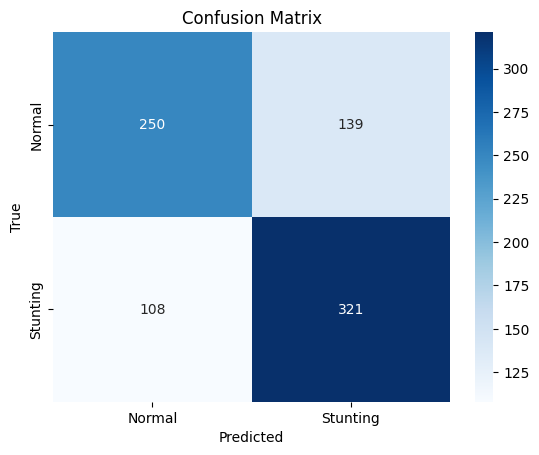

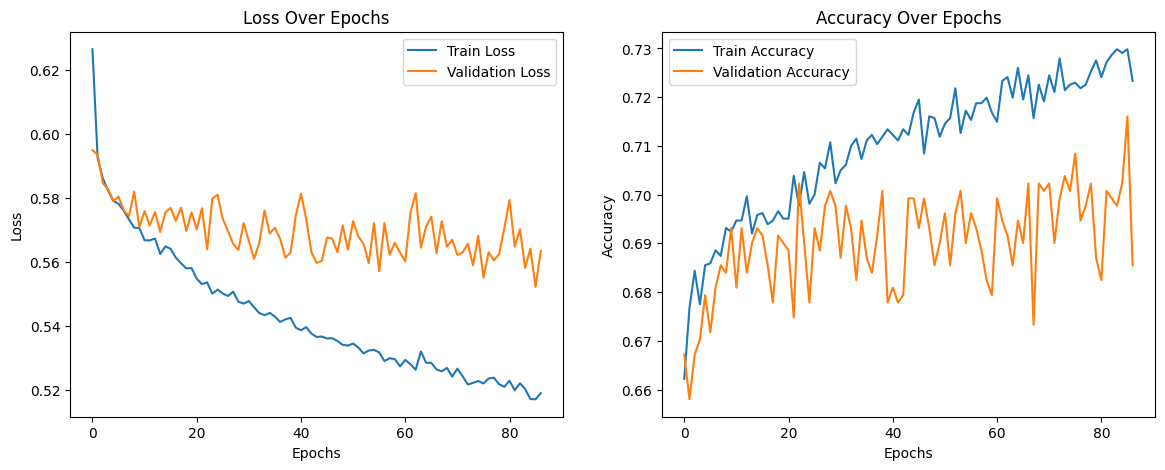

Nama Balita: agus
Usia (bulan): 17
Berat Badan (kg): 9
Tinggi Badan (cm): 60
Jenis Kelamin (Male/Female): male
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Nama: agus
Status: Stunting


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils import resample

# Load Data
data = pd.read_csv("/content/GroUp/Stunting_Dataset.csv")
data['Stunting'] = data['Stunting'].apply(lambda x: 1 if x == 'Yes' else 0)
data_stunting = data[data['Stunting'] == 1]
data_normal = data[data['Stunting'] == 0]

if len(data_stunting) > len(data_normal):
    data_stunting = resample(data_stunting, replace=False, n_samples=len(data_normal), random_state=42)
else:
    data_normal = resample(data_normal, replace=False, n_samples=len(data_stunting), random_state=42)

data_balanced = pd.concat([data_stunting, data_normal])
data = data_balanced

X = data[['Age', 'Body Weight', 'Body Length', 'Gender']].copy()
X['Gender'] = X['Gender'].apply(lambda x: 1 if x.lower() == 'male' else 0)
y = data['Stunting']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=87, batch_size=16, verbose=1)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stunting'], yticklabels=['Normal', 'Stunting'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

def predict_stunting(age, weight, height, gender):
    gender = 1 if gender.lower() == 'male' else 0
    input_data = scaler.transform([[age, weight, height, gender]])
    prediction = model.predict(input_data)
    status = 'Stunting' if prediction > 0.7 else 'Normal'
    return status

name = input("Nama Balita: ")
age = int(input("Usia (bulan): "))
weight = float(input("Berat Badan (kg): "))
height = float(input("Tinggi Badan (cm): "))
gender = input("Jenis Kelamin (Male/Female): ")

status = predict_stunting(age, weight, height, gender)
print(f"Nama: {name}\nStatus: {status}")


In [29]:
pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unins

In [6]:
# 3. Simpan model ke file .h5
model.save('model.h5')
print("Model berhasil disimpan sebagai 'model.h5'")

Model berhasil disimpan sebagai 'model.h5'


In [7]:
from tensorflow.keras.models import load_model
import tensorflowjs as tfjs

model = load_model("model.h5")
output_path = "tfjs"

tfjs.converters.save_keras_model(model, output_path)

failed to lookup keras version from the file,
    this is likely a weight only file


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Kasus Serupa:
usia : 16.0
jenis kelamin : Male
tinggi badan : 63.0
berat badan : 8.4
status : Stunting
----
usia : 17.0
jenis kelamin : Male
tinggi badan : 63.0
berat badan : 9.0
status : Stunting
----
usia : 17.0
jenis kelamin : Male
tinggi badan : 63.0
berat badan : 9.0
status : Stunting
----


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


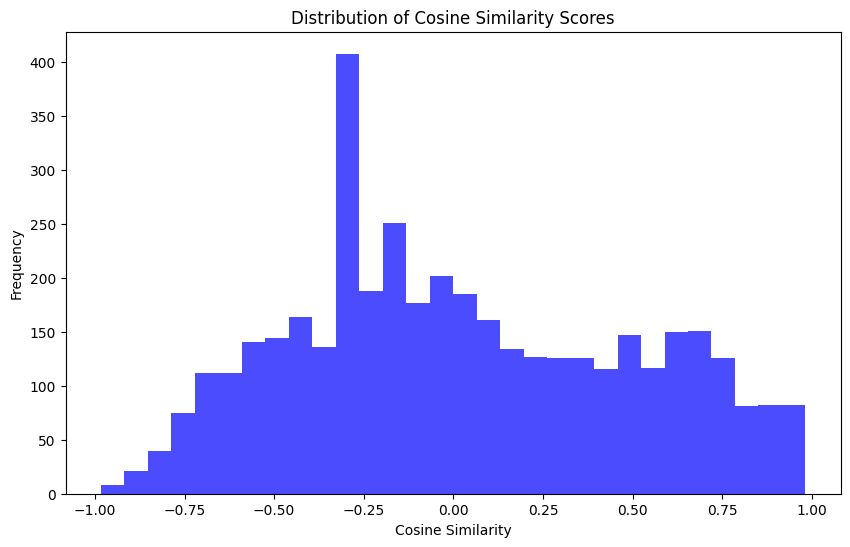

In [26]:
from tensorflow.keras.metrics import CosineSimilarity

def find_similar_cases(age, weight, height, gender, n_cases=3):
    gender = 1 if gender.lower() == 'male' else 0
    input_data = scaler.transform([[age, weight, height, gender]])
    dataset_scaled = scaler.transform(X)

    cosine_sim = tf.keras.metrics.CosineSimilarity()
    similarities = []
    for idx, case in enumerate(dataset_scaled):
        cosine_sim.reset_state()
        cosine_sim.update_state(input_data, [case])
        similarities.append((cosine_sim.result().numpy(), idx))

    similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
    top_cases = similarities[:n_cases]


    results = []
    for _, idx in top_cases:
        case = X.iloc[idx]
        result = {
            "usia": case['Age'],
            "jenis kelamin": 'Male' if case['Gender'] == 1 else 'Female',
            "tinggi badan": case['Body Length'],
            "berat badan": case['Body Weight'],
            "status": 'Stunting' if y.iloc[idx] == 1 else 'Normal'
        }
        results.append(result)
    return results

similar_cases = find_similar_cases(age, weight, height, gender)
print("Kasus Serupa:")
for case in similar_cases:
    for key, value in case.items():
        print(f"{key} : {value}")
    print("----")

def visualize_similarity(age, weight, height, gender):
    gender = 1 if gender.lower() == 'male' else 0
    input_data = scaler.transform([[age, weight, height, gender]])
    dataset_scaled = scaler.transform(X)

    similarities = []
    for case in dataset_scaled:
        cosine_sim = CosineSimilarity()
        similarity = cosine_sim(input_data, [case]).numpy()
        similarities.append(similarity)

    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=30, color='blue', alpha=0.7)
    plt.title("Distribution of Cosine Similarity Scores")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()

visualize_similarity(age, weight, height, gender)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0368 - mae: 0.7216 - val_loss: 1.0018 - val_mae: 0.7125
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9979 - mae: 0.7068 - val_loss: 1.0010 - val_mae: 0.7135
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0141 - mae: 0.7156 - val_loss: 1.0013 - val_mae: 0.7141
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.0208 - mae: 0.7191 - val_loss: 1.0012 - val_mae: 0.7129
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9987 - mae: 0.7091 - val_loss: 1.0006 - val_mae: 0.7134
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9860 - mae: 0.7066 - val_loss: 1.0017 - val_mae: 0.7136
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9903 - mae: 0.7103 - val_loss: 1.0012 - val_mae: 0.7134
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0150 - mae: 0.7182 - val_loss: 1.0017 - val_mae: 0.7134
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0189 

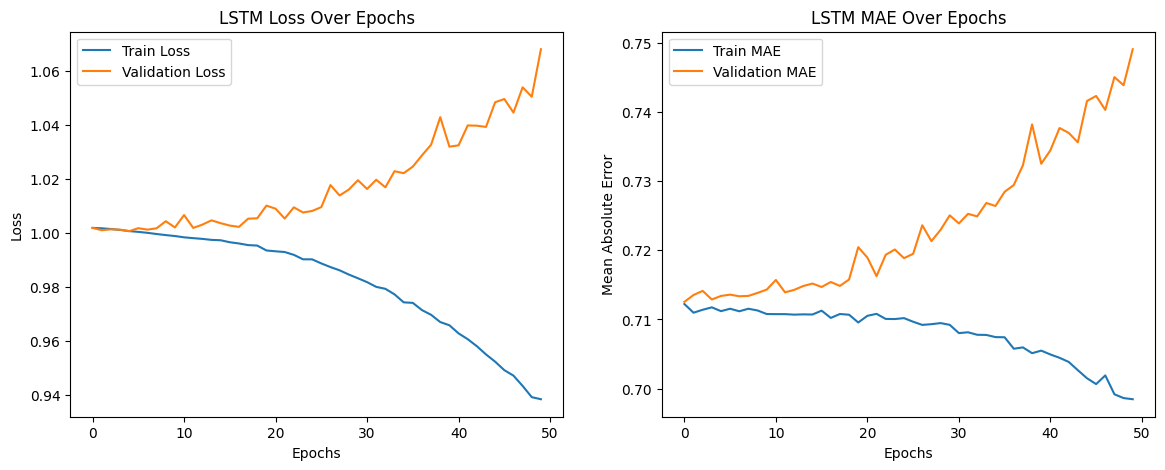

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("/content/GroUp/Stunting_Dataset.csv")
data['Stunting'] = data['Stunting'].apply(lambda x: 1 if x == 'Yes' else 0)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x.lower() == 'male' else 0)

scaler_weight_height = StandardScaler()
scaled_weight_height = scaler_weight_height.fit_transform(data[['Body Weight', 'Body Length']].values)

def prepare_lstm_data(X, y, look_back=1):
    data_X, data_y = [], []
    for i in range(len(X) - look_back):
        data_X.append(X[i:i + look_back])
        data_y.append(y[i + look_back])
    return np.array(data_X), np.array(data_y)

look_back = 3
X_seq, y_seq = prepare_lstm_data(scaled_weight_height, scaled_weight_height, look_back)

X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(look_back, X_seq.shape[2]), return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(2)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

lstm_history = lstm_model.fit(X_seq_train, y_seq_train, validation_split=0.2, epochs=50, batch_size=16, verbose=1)

test_loss, test_mae = lstm_model.evaluate(X_seq_test, y_seq_test, verbose=0)
print(f"LSTM Test MAE: {test_mae:.2f}")

def predict_future_growth(weight, height, status):
    scaled_input = scaler_weight_height.transform([[weight, height]])
    input_seq = np.tile(scaled_input, (look_back, 1))
    input_seq = input_seq.reshape((1, look_back, 2))
    predicted_growth = lstm_model.predict(input_seq)
    weight_3mo, height_3mo = scaler_weight_height.inverse_transform(predicted_growth)[0]

    if status.lower() == "stunting":
        weight_3mo *= 0.9
        height_3mo *= 0.95
    elif status.lower() == "normal":
        weight_3mo *= 1.1
        height_3mo *= 1.05

    return {
        "status": status,
        "predicted_weight": weight_3mo,
        "predicted_height": height_3mo
    }

def plot_lstm_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('LSTM Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.title('LSTM MAE Over Epochs')

    plt.show()

name = input("Nama Balita: ")
age = int(input("Usia (bulan): "))
weight = float(input("Berat Badan (kg): "))
height = float(input("Tinggi Badan (cm): "))
gender = input("Jenis Kelamin (Male/Female): ")

gender = gender.lower()
stunting_result = predict_future_growth(weight, height, "Stunting")
print(f"\nStatus: {stunting_result['status']}")
print(f"Tinggi Badan (3 bulan ke depan): {stunting_result['predicted_height']:.2f} cm")
print(f"Berat Badan (3 bulan ke depan): {stunting_result['predicted_weight']:.2f} kg")

normal_result = predict_future_growth(weight, height, "Normal")
print(f"\nStatus: {normal_result['status']}")
print(f"Tinggi Badan (3 bulan ke depan): {normal_result['predicted_height']:.2f} cm")
print(f"Berat Badan (3 bulan ke depan): {normal_result['predicted_weight']:.2f} kg")

plot_lstm_history(lstm_history)
